# Predicting Heart Disease Based on Relevant Body Data in Switzerland

### Group member:
Anyna Wang 53713814

Lindsay Watson 62396171

Yiman Ma 22858963

## Introduction:

##### Background information
Many people do not know they have heart disease until it happens. However, with modern technology, we can predict how likely people are to have heart disease based on information like age, blood pressure, and heart rate. Thus, patients can prevent and monitor their heart health in advance. “It has been shown that an increase in heart rate by 10 beats per minute was associated with an increase in the risk of cardiac death, and this increase in the risk is similar with an increase in systolic blood pressure by 10 mm Hg'' (Perret-Guillaume et al., 2009). Study shows that among the risks that cause cardiovascular disease, high blood pressure has a strong association with heart disease. (Savoia, 2003)
##### State the question
Therefore, our question is, are age, maximum heart rate, and resting blood pressure strongly associated with the diagnosis of heart disease? If so, can we accurately predict the diagnosis of heart disease with these three predictors? KNN classification algorithms will be used to predict the diagnosis. We will also estimate the accuracy of our model to predict the disease.
##### Identify and describe the dataset
The data set is from the UCI machine learning repository. It consists of 303 patient instances from Switzerland and each row presents a piece of information about patients. Each patient has 14 kinds of physical health data, such as age, gender, resting blood pressure, fasting blood sugar and so on. The "?" in the data set means that the data does not exist.

## Method & Results

In [16]:
### Run this cell before continuing.
library(tidyverse)
library(tidymodels)
library(digest)
library(repr)
library("themis")
library(ggplot2)
library(cowplot)
library(testthat)
options(repr.matrix.max.rows = 6)

#### 1.Loading data from the original source on the web

We have imported and organized Switzerland heart disease data, established variable names, changed variable types, and finally removed unrealistic and useless information.

In [17]:
# The url is a copy link of heart disease data set from UCI Machine Learning Repository website.
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data"

# Naming each columns based on the information from UCI Machine Learning Repository.
names <- c("age",
           "sex",
           "chest_pain_type",
           "resting_blood_pressure",
           "serum_cholestoral (mg/dl)",
           "fasting_blood_sugar",
           "resting_electrocardiographic_results",
           "maximum_heart_rate",
           "exercise_induced_angina",
           "ST_depression",
           "slope_of_the_peak_exercise_ST_segment",
           "number_of_major_vessels",
           "thal",
           "diagnosis_of_heart_disease")

# Loading processed switzerland heart disease data set
original_switzerland_data <- read_delim(url, delim = ",", col_names = names) |>

                             # making categorie variables as a factor
                             mutate(across(sex : chest_pain_type, as_factor)) |>
                             mutate(across(fasting_blood_sugar : resting_electrocardiographic_results, as_factor)) |>
                             mutate(exercise_induced_angina = as_factor(exercise_induced_angina)) |>
                             mutate(slope_of_the_peak_exercise_ST_segment = as_factor(slope_of_the_peak_exercise_ST_segment)) |>
                             mutate(thal = as_factor(thal)) |>

                             # making age as a integer, because it can't have negative and decimals.
                             mutate(age = as.integer(age)) |>
                    
                             # making number of major vessels as integer, because it has a range with 0-3.
                             mutate(number_of_major_vessels = as.integer(number_of_major_vessels)) |>

                             # making quantitative variables as a double
                             mutate(resting_blood_pressure = as.double(resting_blood_pressure)) |>
                             mutate(maximum_heart_rate = as.double(maximum_heart_rate)) |>
                             mutate(ST_depression = as.double(ST_depression)) 

# If diagnosis of heart disease is 0 
original_switzerland_data$diagnosis_of_heart_disease <- ifelse(original_switzerland_data$diagnosis_of_heart_disease == 0, "false", "true")

# It is impossible to have 0 blood pressure, delate the impossible data. 
# Making diagnosis of heart disease as factor
original_switzerland_data <- original_switzerland_data |>
                             filter(resting_blood_pressure != 0) |>
                             mutate(diagnosis_of_heart_disease = as_factor(diagnosis_of_heart_disease))

# Data can not be "?", replace "?" to NA
original_switzerland_data <- replace(original_switzerland_data , original_switzerland_data == "?", NA)

# First 6 row of the data set
head(original_switzerland_data)

Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): resting_blood_pressure, fasting_blood_sugar, resting_electrocardiog...
dbl (5): age, sex, chest_pain_type, serum_cholestoral (mg/dl), diagnosis_of_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,chest_pain_type,resting_blood_pressure,serum_cholestoral (mg/dl),fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate,exercise_induced_angina,ST_depression,slope_of_the_peak_exercise_ST_segment,number_of_major_vessels,thal,diagnosis_of_heart_disease
<int>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>
32,1,1,95,0,NA,0,127,0,0.7,1,NA,NA,true
34,1,4,115,0,NA,NA,154,0,0.2,1,NA,NA,true
36,1,4,110,0,NA,0,125,1,1.0,2,NA,6,true
38,0,4,105,0,NA,0,166,0,2.8,1,NA,NA,true
38,0,4,110,0,0,0,156,0,0.0,2,NA,3,true
38,1,3,100,0,NA,0,179,0,-1.1,1,NA,NA,false


#### 2. Wrangling and cleaning the data from original

We selected three variables: resting blood pressure, maximum heart rate, and age, from the 14 variables in the database to predict the diagnosis of heart disease. We used these three variables because research has linked elevated resting blood pressure and maximum heart rate to heart disease.

In [18]:
# wrangle data set, select the columns that the research will use.
switzerland_heart_disease_data <- original_switzerland_data |> 
             select(age, resting_blood_pressure, maximum_heart_rate, diagnosis_of_heart_disease)

head(switzerland_heart_disease_data)

age,resting_blood_pressure,maximum_heart_rate,diagnosis_of_heart_disease
<int>,<dbl>,<dbl>,<fct>
32,95,127,true
34,115,154,true
36,110,125,true
38,105,166,true
38,110,156,true
38,100,179,false


#### 3. Performing a summary

We seeded the dataset for random splits to ensure reproducible results. Then, we split the data into training and testing datasets. The training dataset is used to build the classifier, and the testing dataset is used to evaluate the accuracy of the classifier's predictions. We hope to use three quantitative variables (resting blood pressure, maximum heart rate, and age) to predict whether there is a categorical variable of heart disease.

In [19]:
# Making the training data set and testing data set
set.seed(2700)
heart_disease_split <- initial_split(switzerland_heart_disease_data, prop = 0.75, strata = diagnosis_of_heart_disease)
heart_disease_training_data <- training(heart_disease_split)
heart_disease_testing_data <- testing(heart_disease_split)
heart_disease_training_data
heart_disease_testing_data

age,resting_blood_pressure,maximum_heart_rate,diagnosis_of_heart_disease
<int>,<dbl>,<dbl>,<fct>
32,95,127,true
36,110,125,true
38,105,166,true
⋮,⋮,⋮,⋮
70,140,157,true
72,160,114,false
73,160,121,true


age,resting_blood_pressure,maximum_heart_rate,diagnosis_of_heart_disease
<int>,<dbl>,<dbl>,<fct>
34,115,154,true
38,150,120,true
42,145,99,true
⋮,⋮,⋮,⋮
65,160,122,true
66,150,108,true
74,145,123,true


We explored the training heart disease dataset. The summary contains the number of each category (with or without heart disease) in the testing dataset, and the average of the three quantitative variables.

In [20]:
# Counting rows that have missing data
data_missing_num <- heart_disease_training_data|>
                    map_df(is.na)|>
                    map_df(sum)
data_missing_num

# Counting rows that have data, calculating the mean of age, mean of blood pressure and mean of maximum heart rate
heart_disease_summarize <- heart_disease_training_data|>
                           group_by(diagnosis_of_heart_disease) |>
                           summarize(n_age = sum(!is.na(age)),
                                     n_resting_blood_pressure = sum(!is.na(resting_blood_pressure)),
                                     n_maximum_heart_rate = sum(!is.na(maximum_heart_rate)),
                                     n_diagnosis_of_heart_disease = sum(!is.na(diagnosis_of_heart_disease)),
                                     mean_age = mean(age, na.rm=TRUE),
                                     mean_blood_pressure = mean(resting_blood_pressure, na.rm=TRUE),
                                     mean_heart_rate = mean(maximum_heart_rate, na.rm=TRUE))
heart_disease_summarize

age,resting_blood_pressure,maximum_heart_rate,diagnosis_of_heart_disease
<int>,<int>,<int>,<int>
0,0,0,0


diagnosis_of_heart_disease,n_age,n_resting_blood_pressure,n_maximum_heart_rate,n_diagnosis_of_heart_disease,mean_age,mean_blood_pressure,mean_heart_rate
<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
true,83,83,83,83,55.32530,127.6506,122.8916
false,7,7,7,7,54.57143,122.1429,134.7143


#### 4. Creating visualization

We created two scatterplots to visualize resting blood pressure and maximum heart rate as a function of age. And the existence of heart disease and the absence of heart disease are used as two classifications, and the points in the picture are divided into two different colors. We wanted to find the relationship between these two variables, first to see if they are strongly correlated, and then to see if this relationship can be used to predict a heart disease diagnosis.

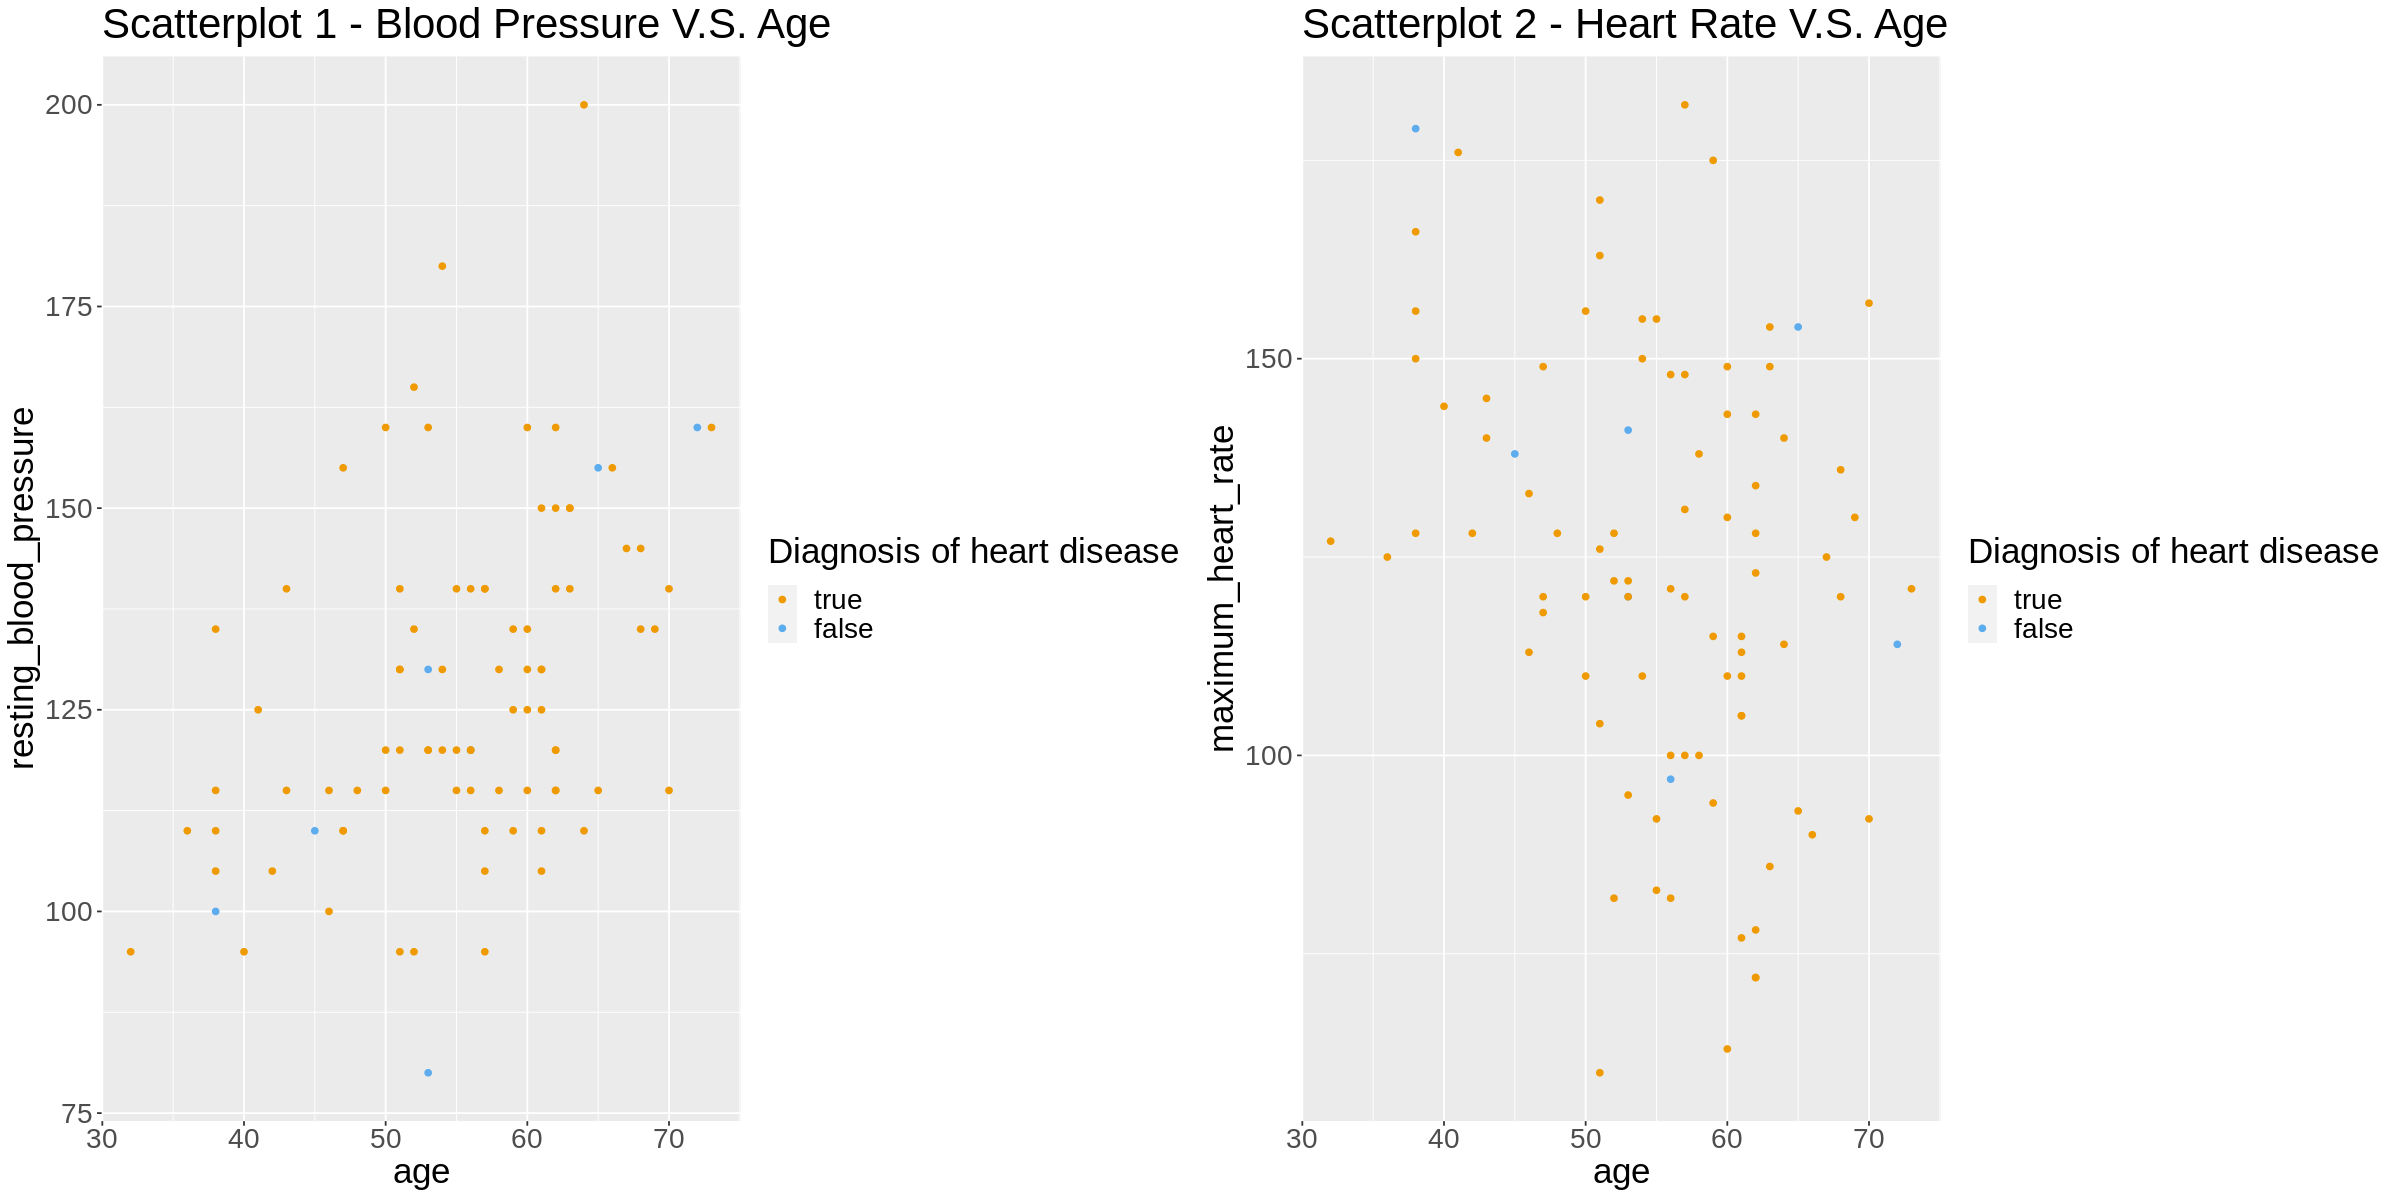

In [21]:
# Create a scatterplot to visualize the relationship between two quantitative variables, categorized by the presence or 
# absence of heart disease
# The following creates 2 scatterplots: Blood Pressure V.S. Age, Heart Rate V.S. Age
Age_BP <- heart_disease_training_data |>
    ggplot(aes(x = age, y = resting_blood_pressure, color = diagnosis_of_heart_disease)) +
    geom_point(alpha = 5) +
    labs(color = "Diagnosis of heart disease") +
    ggtitle("Scatterplot 1 - Blood Pressure V.S. Age")+
    scale_color_manual(labels = c("true", "false"), 
                       values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 21))

Age_HR <- heart_disease_training_data |>
    ggplot(aes(x = age, y = maximum_heart_rate, color = diagnosis_of_heart_disease)) +
    geom_point(alpha = 5) +
    labs(color = "Diagnosis of heart disease") +
    ggtitle("Scatterplot 2 - Heart Rate V.S. Age")+
    scale_color_manual(labels = c("true", "false"), 
                       values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 21))

#plot two graphs together
plot_grid(Age_BP, Age_HR)
options(repr.plot.width = 20 ,repr.plot.height = 10)

In order to study whether age, resting blood pressure, and maximum heart rate are related to the presence of heart disease, we also drew proportional bar graphs for these three variables to more intuitively observe their relationship with heart disease.

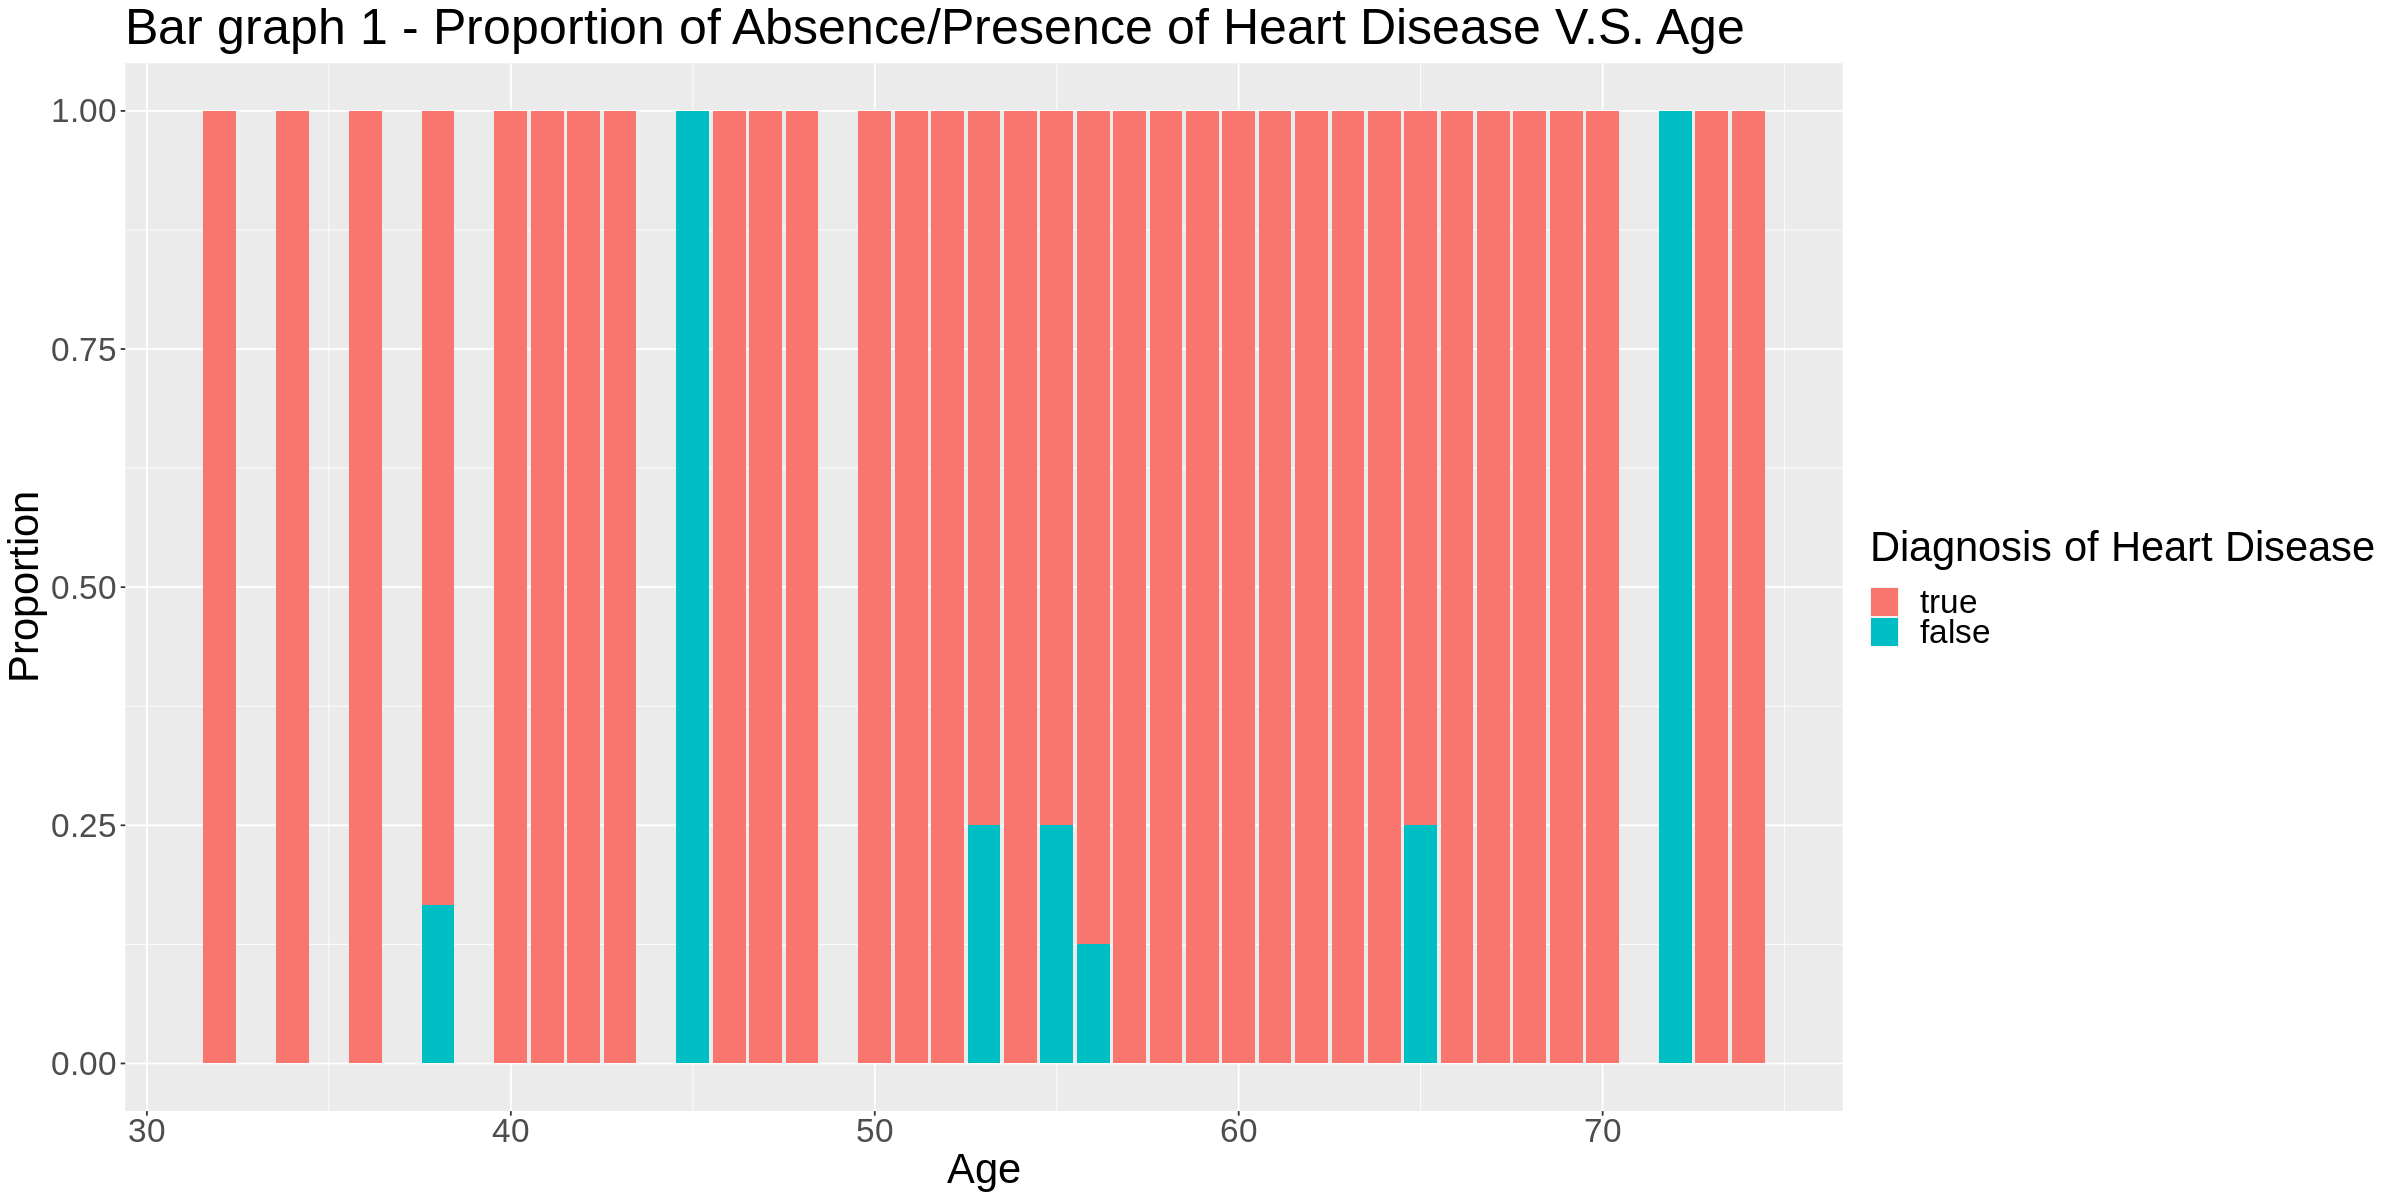

In [22]:
age_graph <- ggplot(data = switzerland_heart_disease_data, aes(x = age, fill = diagnosis_of_heart_disease)) + 
            geom_bar(position = "fill") +
            labs(x = "Age",y = "Proportion", fill = "Diagnosis of Heart Disease") +
            ggtitle("Bar graph 1 - Proportion of Absence/Presence of Heart Disease V.S. Age") +
            theme(text = element_text(size = 25))
age_graph

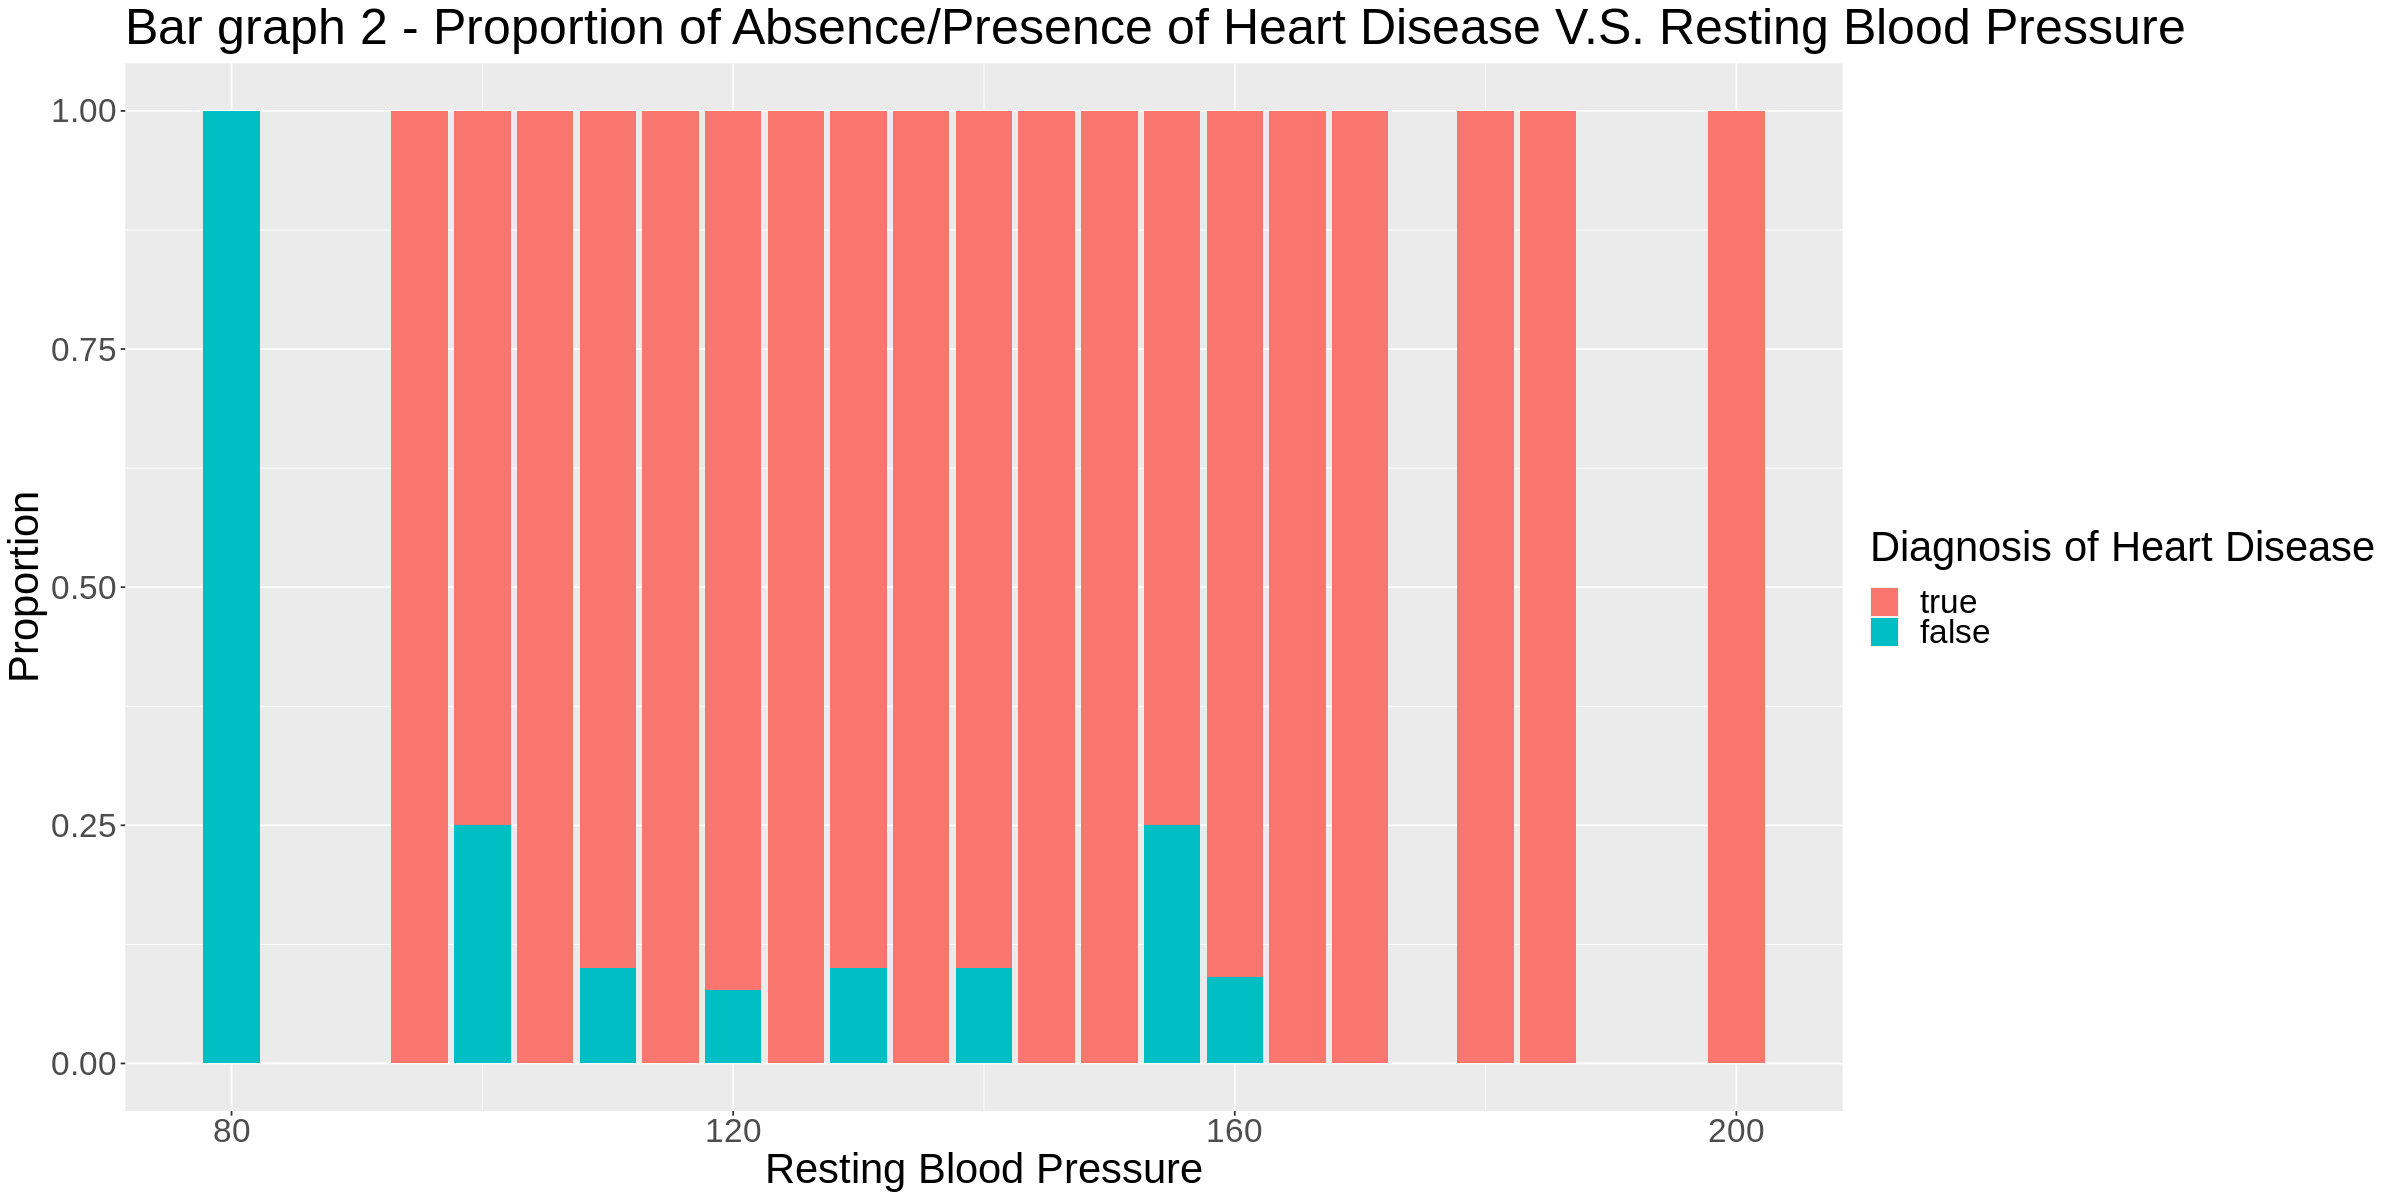

In [23]:
age_graph <- ggplot(data = switzerland_heart_disease_data, aes(x = resting_blood_pressure, fill = diagnosis_of_heart_disease)) + 
            geom_bar(position = "fill") +
            labs(x = "Resting Blood Pressure",y = "Proportion", fill = "Diagnosis of Heart Disease") +
            ggtitle("Bar graph 2 - Proportion of Absence/Presence of Heart Disease V.S. Resting Blood Pressure") +
            theme(text = element_text(size = 25))
age_graph

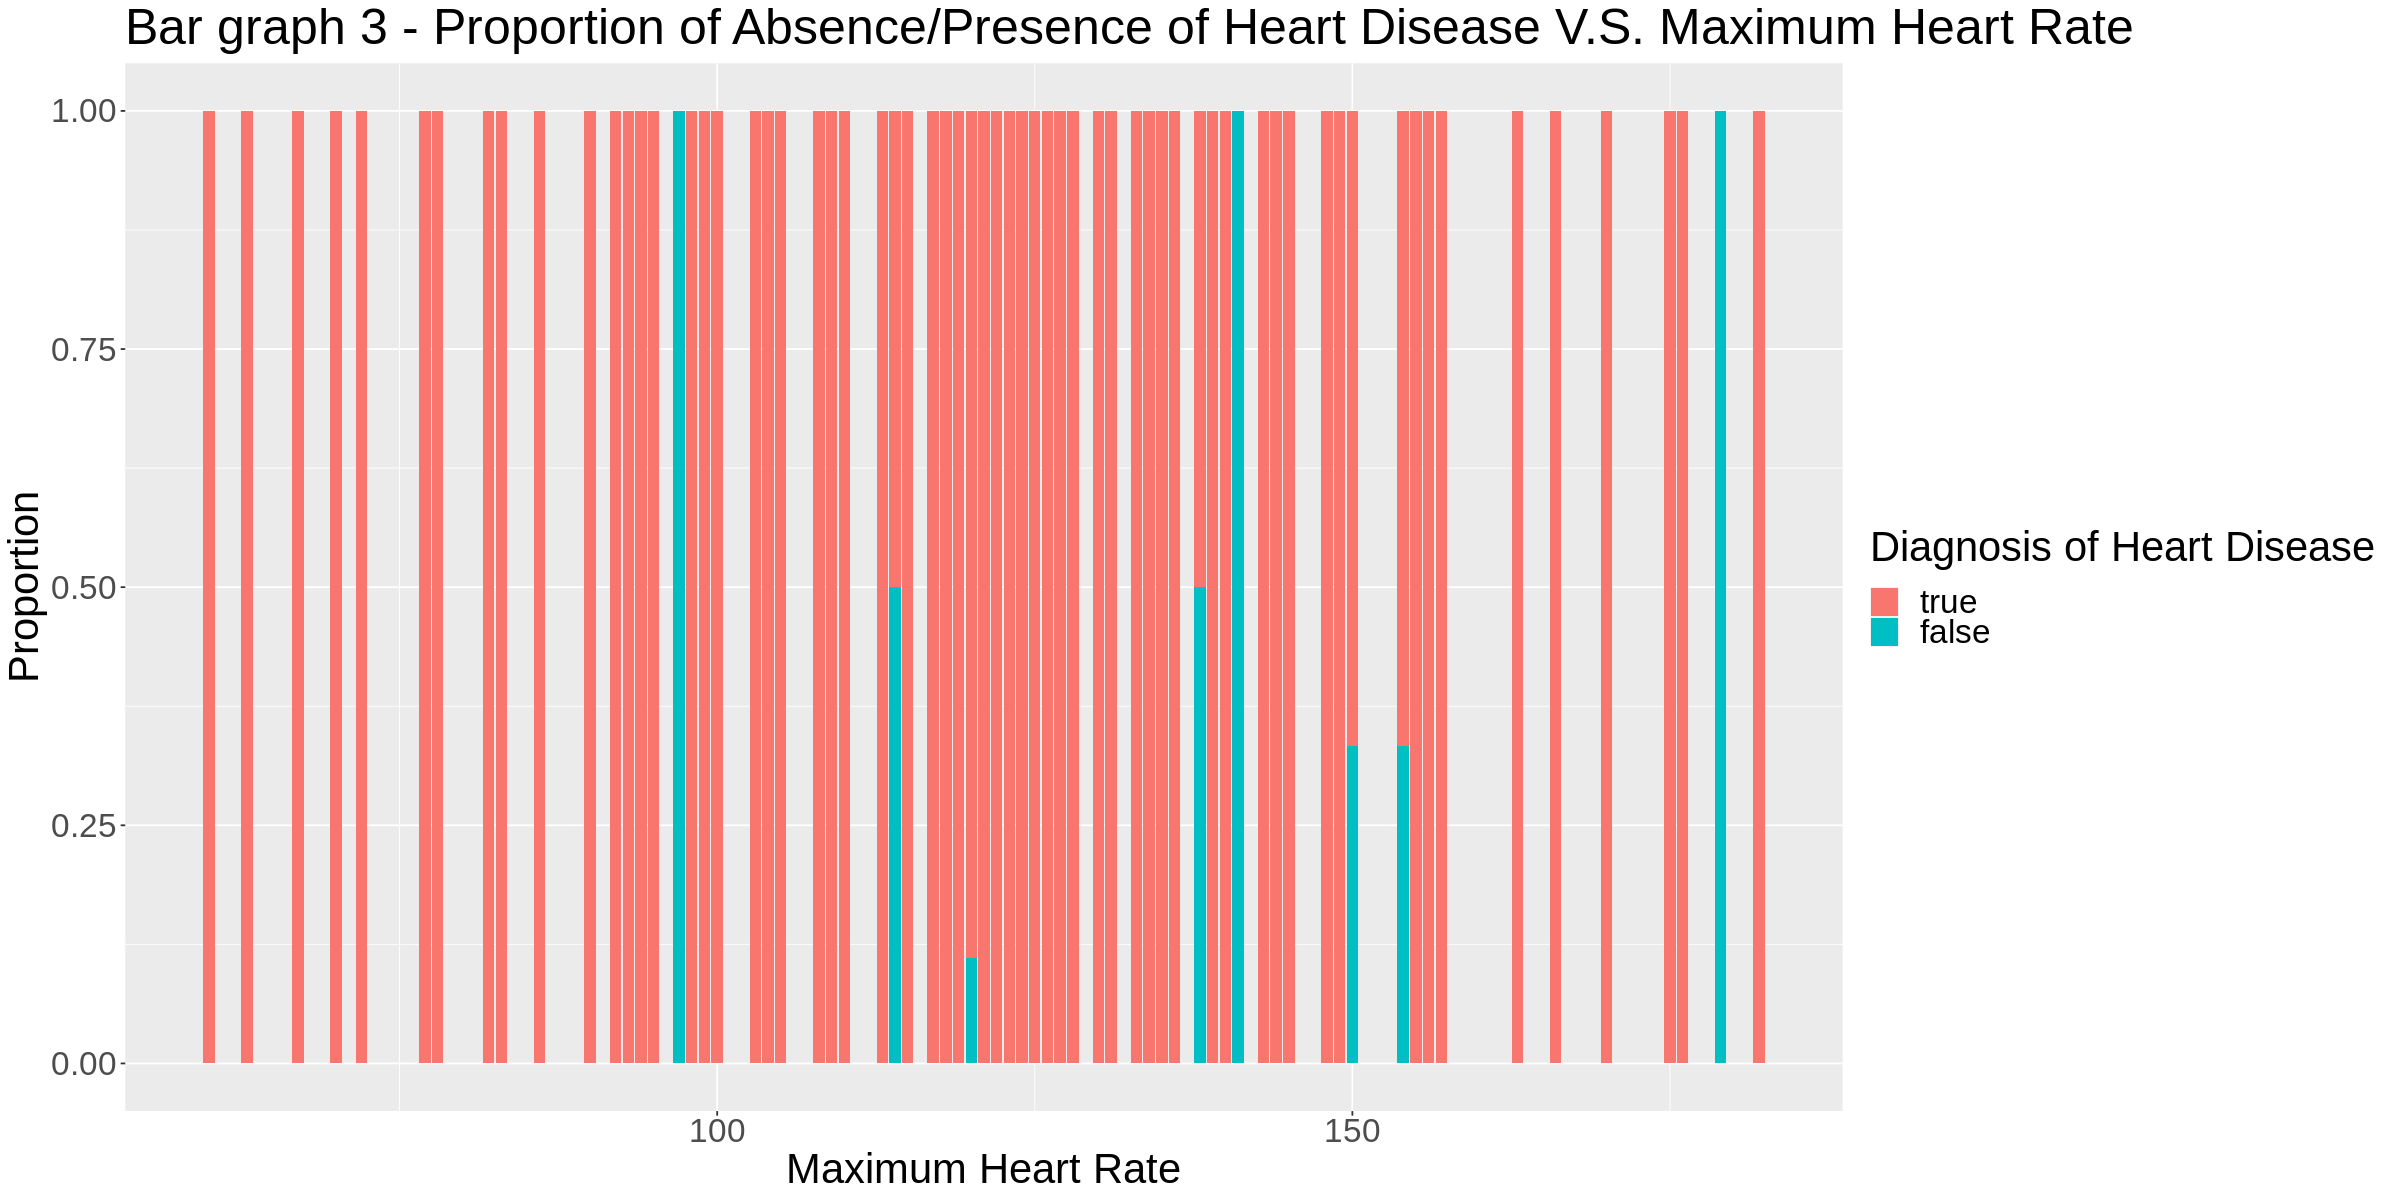

In [24]:
age_graph <- ggplot(data = switzerland_heart_disease_data, aes(x = maximum_heart_rate, fill = diagnosis_of_heart_disease)) + 
            geom_bar(position = "fill") +
            labs(x = "Maximum Heart Rate",y = "Proportion", fill = "Diagnosis of Heart Disease") +
            ggtitle("Bar graph 3 - Proportion of Absence/Presence of Heart Disease V.S. Maximum Heart Rate") +
            theme(text = element_text(size = 25))
age_graph

#### 5. Performing the data analysis

Since the target variable is a categorical variable, K-nearest neighbors classification is performed on the data. We found the appropriate K value according to the three data variables of age, resting blood pressure, and maximum heart rate in the training dataset. First, we created the standardized recipe and fit the KNN model. The training dataset was folded, and the more folds, the more accurate the data is. We then chose a sequence of k values to try the model on and got the accuracy for each k value. Finally, we drew the relationship between the accuracy rate and K to determine what the K-nearest neighbor should be.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9397059,5,0.0009005477,Preprocessor1_Model01
2,accuracy,binary,0.9397059,5,0.0009005477,Preprocessor1_Model02
3,accuracy,binary,0.8794118,5,0.0211405051,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
30,accuracy,binary,0.6727941,5,0.03986471,Preprocessor1_Model30
23,accuracy,binary,0.6569853,5,0.02936347,Preprocessor1_Model23
24,accuracy,binary,0.6569853,5,0.02936347,Preprocessor1_Model24


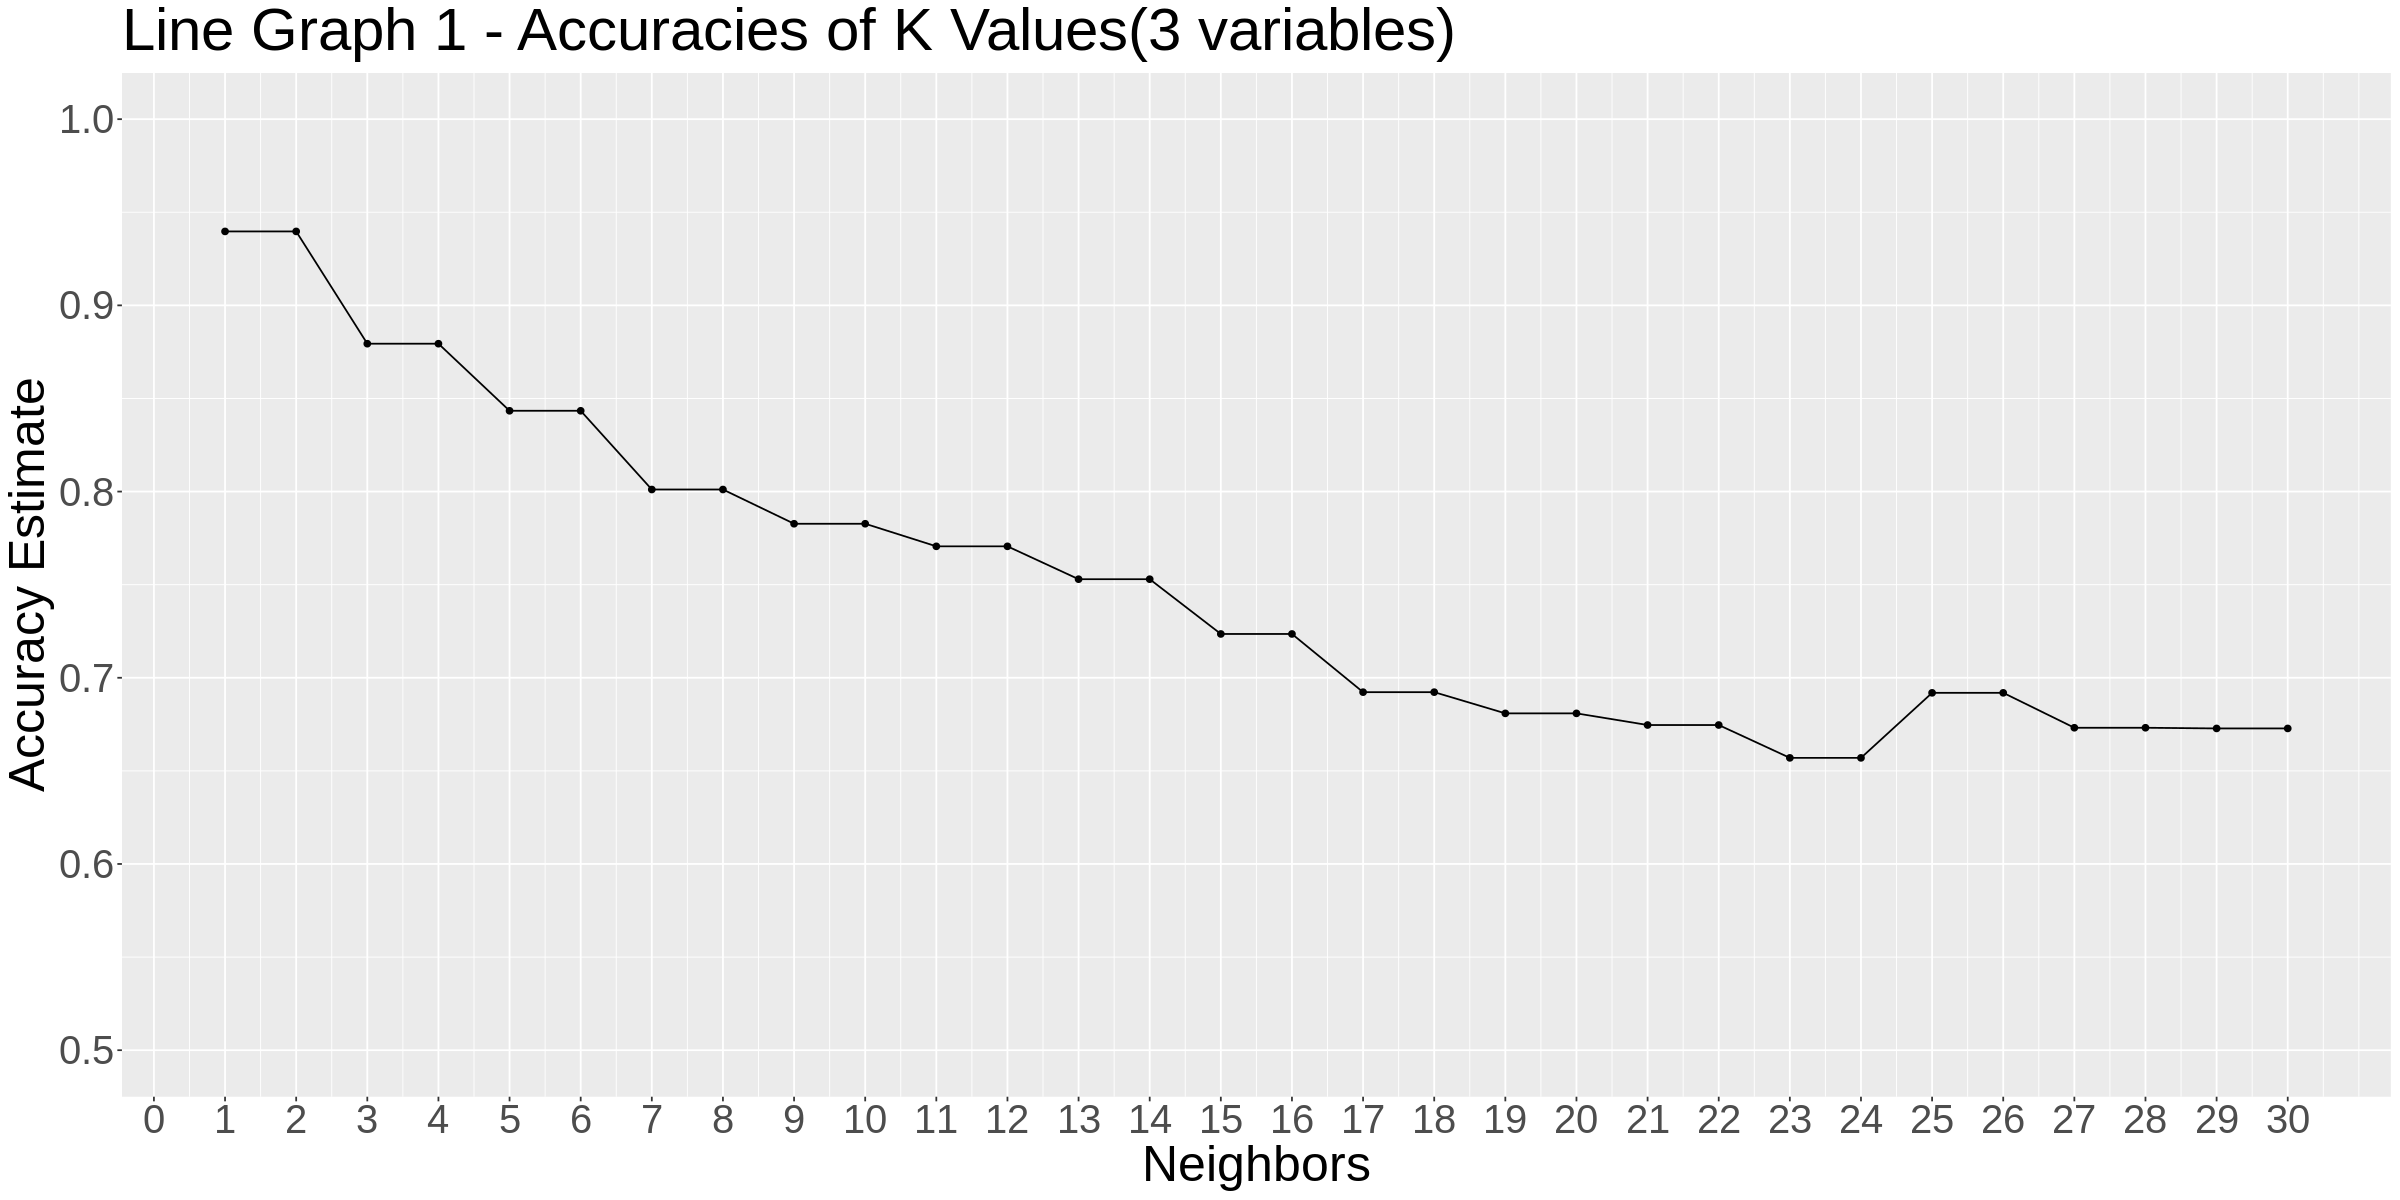

In [38]:
set.seed(2700)
unsample_recipe_1 <- recipe(diagnosis_of_heart_disease ~ age + resting_blood_pressure + maximum_heart_rate, data = heart_disease_training_data)|>
    step_upsample(diagnosis_of_heart_disease, over_ratio = 1, skip = FALSE) |>
    prep()

unsample_disease_1 <- bake(unsample_recipe_1, heart_disease_training_data)

heart_disease_recipe_1 <- recipe(diagnosis_of_heart_disease ~ age + resting_blood_pressure + maximum_heart_rate, data = unsample_disease_1) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

knn_spec_tune_1 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_disease_vfold_1 <- vfold_cv(unsample_disease_1, v = 5, strata = diagnosis_of_heart_disease)

k_vals_1 <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

knn_results_1 <- workflow() |>
    add_recipe(heart_disease_recipe_1) |>
    add_model(knn_spec_tune_1) |>
    tune_grid(resamples = heart_disease_vfold_1, grid = k_vals_1) |>
    collect_metrics() 

accuracies_1 <- knn_results_1 |>
    filter(.metric == "accuracy")

accuracy_vs_k_1 <- ggplot(accuracies_1, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    ggtitle("Line Graph 1 - Accuracies of K Values(3 variables)") +
    theme(text = element_text(size = 30)) +
    scale_x_continuous(breaks = seq(0, 30, by = 1)) +  
    scale_y_continuous(limits = c(0.5, 1.0)) 

accuracy_vs_k_1

max_accuracies_1 <- accuracies_1|>
    arrange(desc(mean))
max_accuracies_1


Sorting the accuracy of each value of k from high to low, we chose 1 as K-neighbors.
Using the classifier to predict heart disease on the testing dataset, using k=1.

In [39]:
set.seed(2700)
knn_spec_1 <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit_1 <- workflow() |>
  add_recipe(heart_disease_recipe_1) |>
  add_model(knn_spec_1) |>
  fit(data = heart_disease_training_data)

heart_test_predictions_1 <- predict(knn_fit_1, heart_disease_testing_data) |>
  bind_cols(heart_disease_testing_data)

accuracy_1 <- heart_test_predictions_1 |>
  metrics(truth = diagnosis_of_heart_disease, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()
accuracy_1

confusion_1 <- heart_test_predictions_1 |>
  conf_mat(truth = diagnosis_of_heart_disease, estimate = .pred_class)
confusion_1


[1] 0.8709677

          Truth
Prediction true false
     true    27     1
     false    3     0

To study whether building a model with separate variables will improve the accuracy of the model. We built new models using resting blood pressure and maximum heart rate separately. We repeated the previous steps of finding suitable K models to obtain the K nearest neighbor values of the two models of the two numerical variables of resting blood pressure and maximum heart rate respectively. K is 1 for the maximum heart rate model and K is 11 for the resting blood pressure model. The two classifiers are then used to predict heart disease on the testing dataset.

#### Using one variable (maximum heart rate) to build model

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8753676,5,0.03966672,Preprocessor1_Model01
4,accuracy,binary,0.8566176,5,0.02588585,Preprocessor1_Model04
2,accuracy,binary,0.8558824,5,0.02489842,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,accuracy,binary,0.5908088,5,0.02948979,Preprocessor1_Model28
29,accuracy,binary,0.5849265,5,0.02084919,Preprocessor1_Model29
30,accuracy,binary,0.5786765,5,0.02332024,Preprocessor1_Model30


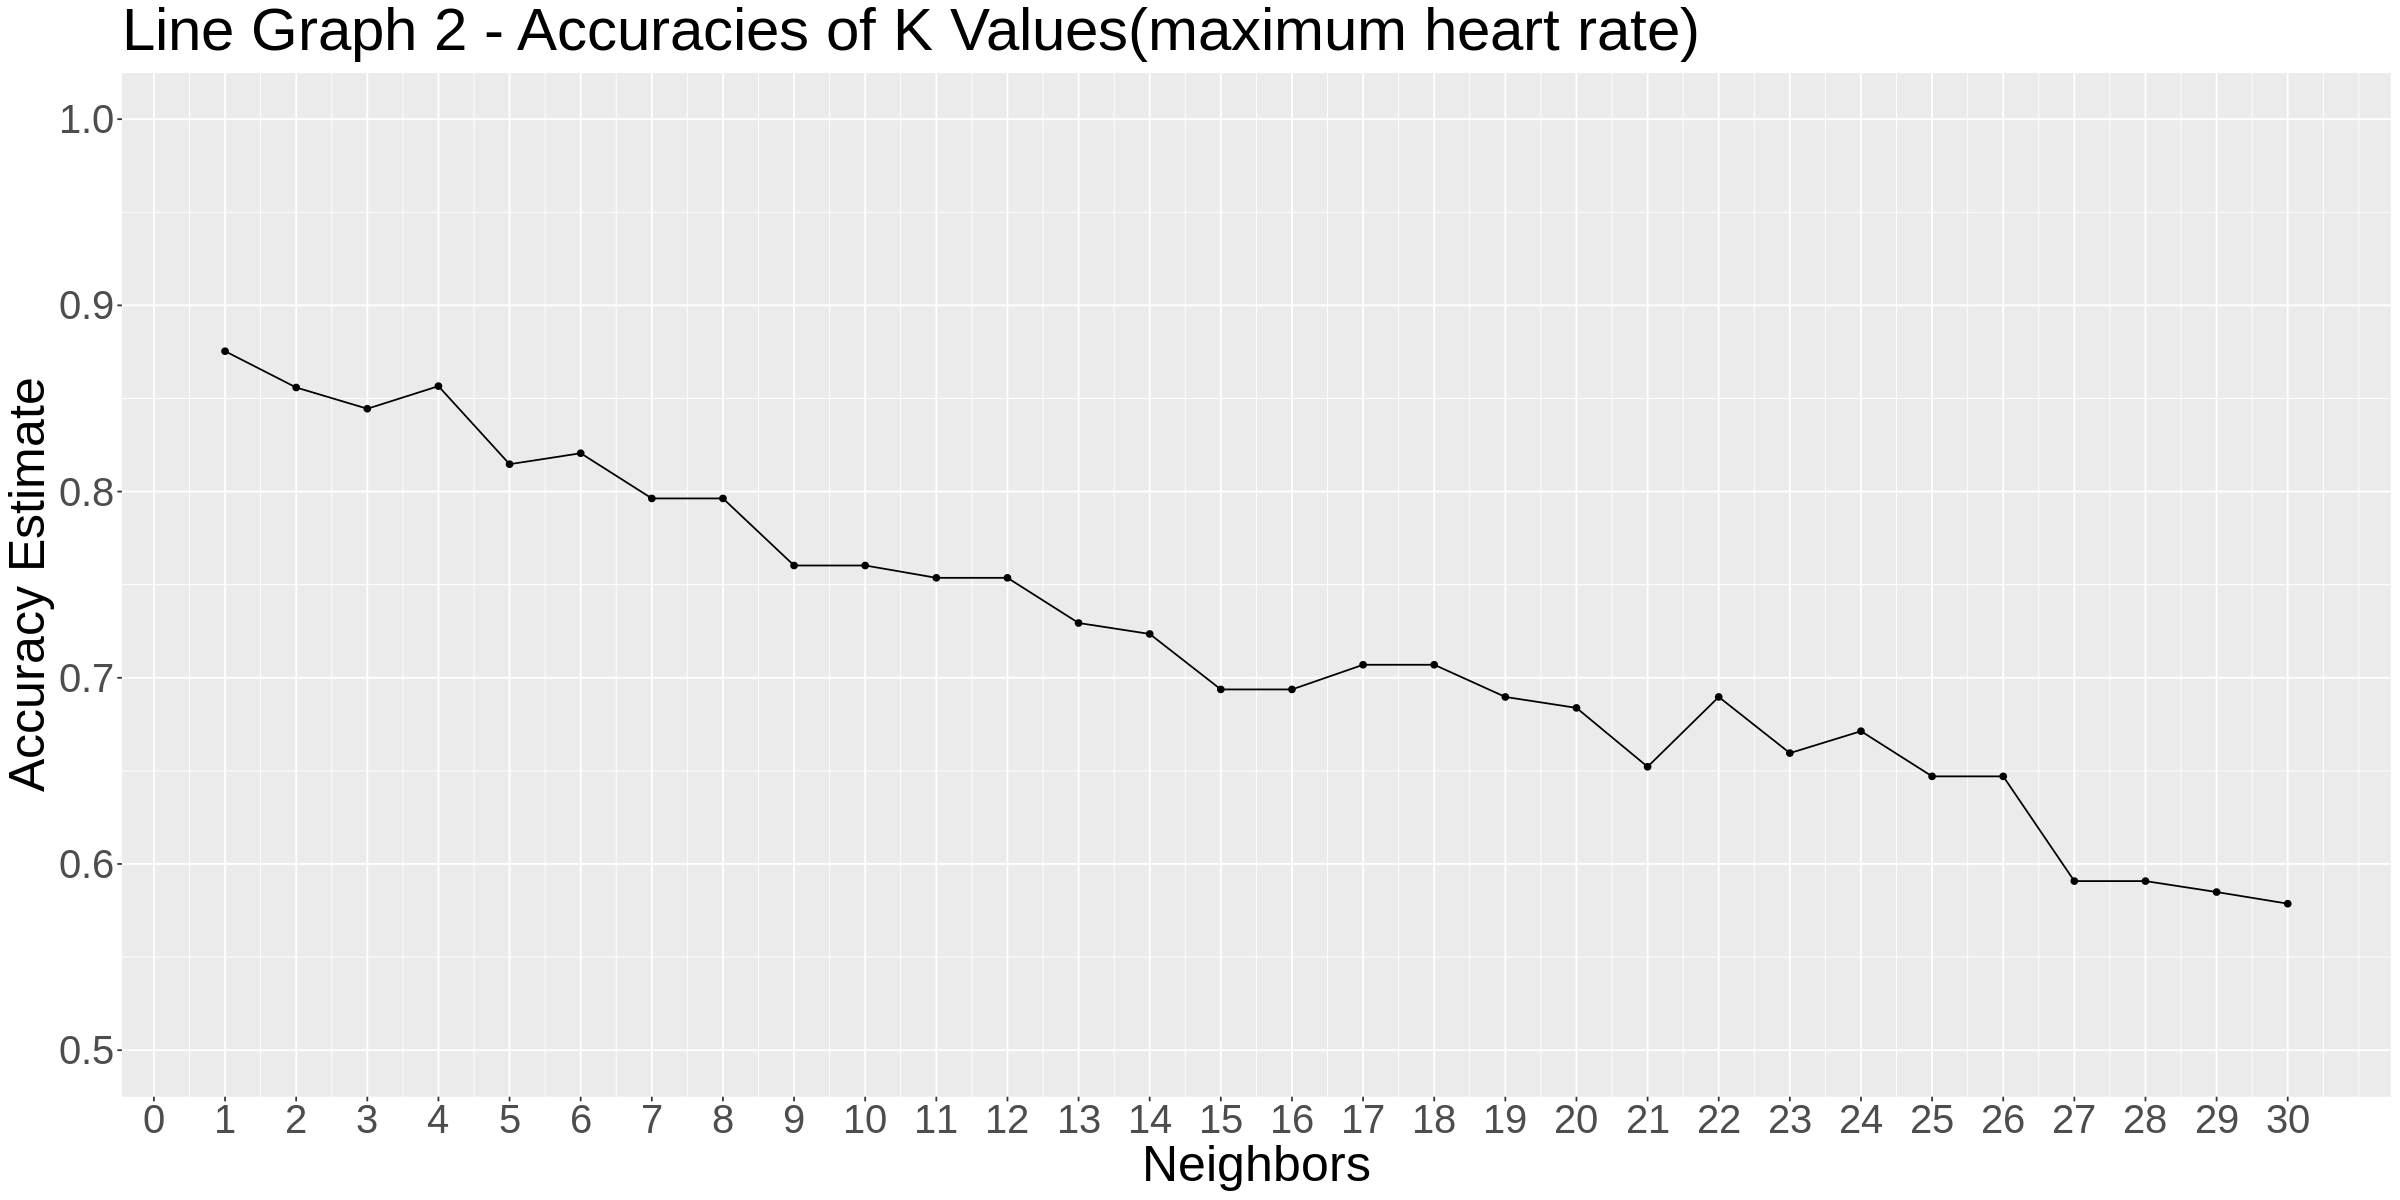

In [52]:
set.seed(2700)
unsample_recipe_2 <- recipe(diagnosis_of_heart_disease ~ maximum_heart_rate, data = heart_disease_training_data)|>
    step_upsample(diagnosis_of_heart_disease, over_ratio = 1, skip = FALSE) |>
    prep()

unsample_disease_2 <- bake(unsample_recipe_2, heart_disease_training_data)

heart_disease_recipe_2 <- recipe(diagnosis_of_heart_disease ~ maximum_heart_rate, data = unsample_disease_2) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec_tune_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_disease_vfold_2 <- vfold_cv(unsample_disease_2, v = 5, strata = diagnosis_of_heart_disease)

k_vals_2 <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

knn_results_2 <- workflow() |>
    add_recipe(heart_disease_recipe_2) |>
    add_model(knn_spec_tune_2) |>
    tune_grid(resamples = heart_disease_vfold_2, grid = k_vals_2) |>
    collect_metrics() 

accuracies_2 <- knn_results_2 |>
    filter(.metric == "accuracy")

accuracy_vs_k_2 <- ggplot(accuracies_2, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
 ggtitle("Line Graph 2 - Accuracies of K Values(maximum heart rate)") +
    theme(text = element_text(size = 30)) +
    scale_x_continuous(breaks = seq(0, 30, by = 1)) +  
    scale_y_continuous(limits = c(0.5, 1.0)) 

accuracy_vs_k_2

max_accuracies_2 <- accuracies_2|>
    arrange(desc(mean))
max_accuracies_2


In [53]:
set.seed(2700)
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit_2 <- workflow() |>
  add_recipe(heart_disease_recipe_2) |>
  add_model(knn_spec_2) |>
  fit(data = heart_disease_training_data)

heart_test_predictions_2 <- predict(knn_fit_2, heart_disease_testing_data) |>
  bind_cols(heart_disease_testing_data)

accuracy_2 <- heart_test_predictions_2 |>
  metrics(truth = diagnosis_of_heart_disease, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()
accuracy_2

confusion_2 <- heart_test_predictions_2 |>
  conf_mat(truth = diagnosis_of_heart_disease, estimate = .pred_class)
confusion_2


[1] 0.8387097

          Truth
Prediction true false
     true    26     1
     false    4     0

#### Using one variable (resting blood pressure) to build model

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,binary,0.7345588,5,0.04156851,Preprocessor1_Model11
12,accuracy,binary,0.7345588,5,0.04156851,Preprocessor1_Model12
25,accuracy,binary,0.7283088,5,0.03365728,Preprocessor1_Model25
⋮,⋮,⋮,⋮,⋮,⋮,⋮
4,accuracy,binary,0.6569853,5,0.007833557,Preprocessor1_Model04
1,accuracy,binary,0.6088235,5,0.032173844,Preprocessor1_Model01
2,accuracy,binary,0.5852941,5,0.021140505,Preprocessor1_Model02


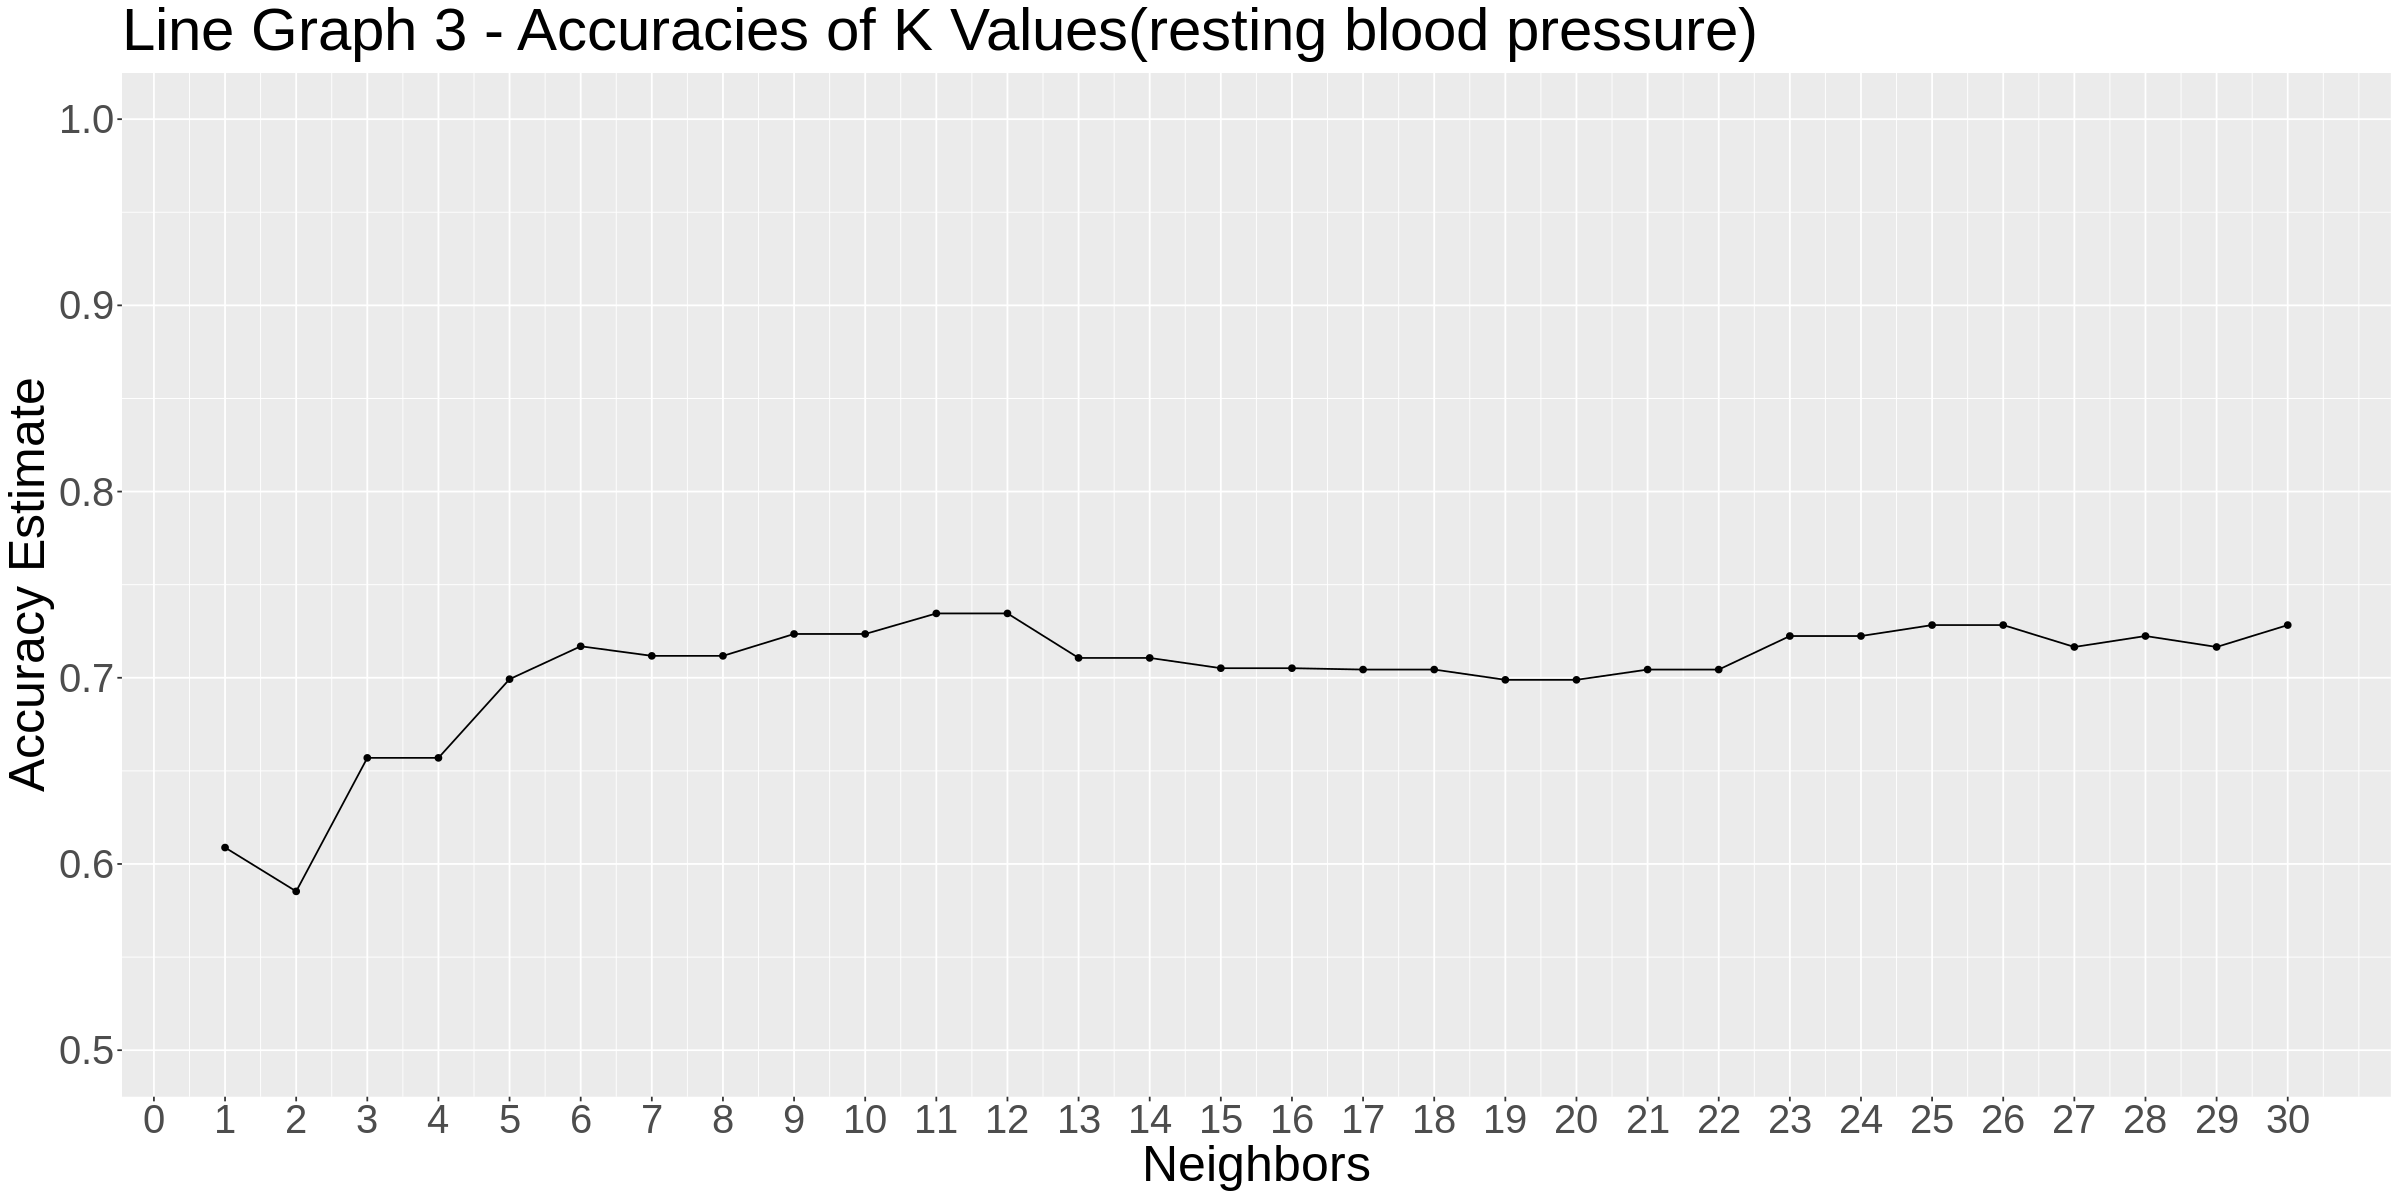

In [56]:
set.seed(2700)
unsample_recipe_3 <- recipe(diagnosis_of_heart_disease ~ resting_blood_pressure, data = heart_disease_training_data)|>
    step_upsample(diagnosis_of_heart_disease, over_ratio = 1, skip = FALSE) |>
    prep()

unsample_disease_3 <- bake(unsample_recipe_3, heart_disease_training_data)

heart_disease_recipe_3 <- recipe(diagnosis_of_heart_disease ~ resting_blood_pressure, data = unsample_disease_3) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec_tune_3 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_disease_vfold_3 <- vfold_cv(unsample_disease_3, v = 5, strata = diagnosis_of_heart_disease)

k_vals_3 <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

knn_results_3 <- workflow() |>
    add_recipe(heart_disease_recipe_3) |>
    add_model(knn_spec_tune_3) |>
    tune_grid(resamples = heart_disease_vfold_3, grid = k_vals_3) |>
    collect_metrics() 

accuracies_3 <- knn_results_3 |>
    filter(.metric == "accuracy")

accuracy_vs_k_3 <- ggplot(accuracies_3, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    ggtitle("Line Graph 3 - Accuracies of K Values(resting blood pressure)") +
    theme(text = element_text(size = 30)) +
    scale_x_continuous(breaks = seq(0, 30, by = 1)) +  
    scale_y_continuous(limits = c(0.5, 1.0)) 

accuracy_vs_k_3

max_accuracies_3 <- accuracies_3|>
    arrange(desc(mean))
max_accuracies_3


In [57]:
set.seed(2700)
knn_spec_3 <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit_3 <- workflow() |>
  add_recipe(heart_disease_recipe_3) |>
  add_model(knn_spec_3) |>
  fit(data = heart_disease_training_data)

heart_test_predictions_3 <- predict(knn_fit_3, heart_disease_testing_data) |>
  bind_cols(heart_disease_testing_data)

accuracy_3 <- heart_test_predictions_3 |>
  metrics(truth = diagnosis_of_heart_disease, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()
accuracy_3

confusion_3 <- heart_test_predictions_3 |>
  conf_mat(truth = diagnosis_of_heart_disease, estimate = .pred_class)
confusion_3


[1] 0.9677419

          Truth
Prediction true false
     true    30     1
     false    0     0

#### Results:
Results of scatter plot 1 shows a weakly positive relationship between resting blood pressure and age, and scatterplot 2 shows a weakly negative relationship between maximum heart rate and age. Then using bar graphs, we found no predictable relationship in bar graph 1 (heart disease vs age) and no predictable relationship in bar graph 3 (heart disease vs maximum heart rate), but found that in bar graph 2, that as resting blood pressure increases, the diagnosis of heart disease increases too. 

For our line graphs which plot the relationship between K nearest neighbour values and mean estimate, we found some interesting results. For Line Graph 1 (accuracies of K values with all 3 of our predictor variables), we found that the best k value to use is k=1. We then found that using k=1 with all three predictor variables gave us an accuracy of 0.871. However, we were curious to see if this accuracy could be improved/which variables were most important in predicting heart disease. 

Therefore, we re-trained the model using just maximum heart rate as a predictor variable and Line Graph 2 achieved the best k value as k=1. We then found that using k=1 with maximum heart rate as the only predictor variable gave us an accuracy of 0.839. This is less accurate than our model with all three predictor variables, so we wanted to try using resting blood pressure as our only predictor variable. Next, we re-trained the model using just resting blood pressure as a predictor variable and Line Graph 3 achieved the best k value as k=11. We then found that using k=11 with resting blood pressure as the predictor variable gave us a higher accuracy of 0.968. 

As a result, we concluded that the model with the highest accuracy of 97% using only the resting blood pressure predictor variable, was the best model for predicting heart disease. 

## Discussion:
##### Summary:
We created a KNN classifier to predict the presence of heart disease using the data from cardiovascular patients. Based on research we found, we wanted to use the three variables age, resting blood pressure, and maximum heart rate to see if they could predict the presence or absence of heart disease. To do this we used a KNN classification and found that these three predictor variables were able to accurately predict the presence of heart disease to an accuracy of 87%. We thought that for an important life or death matter such as heart disease, this accuracy was too low for a model. So, we were curious to see if we could improve the accuracy using only resting blood pressure or maximum heart rate. In doing this, 
We found that maximum heart rate as a separate predictor variable could predict the presence of heart disease with an accuracy of 84%, and that resting blood pressure could predict the presence of heart disease with an accuracy of 97%. This actually makes a lot of sense because when comparing our results to our bar graphs, the only strong relationship found was between increasing blood pressure and an increase in the presence of heart disease. We think that an accuracy of 97% is a pretty accurate number to predict heart disease in real life. Only one of 31 cases was wrongly predicted as having heart disease. Thus, we would say it is quite reliable.

##### Expectation for findings:
Through our data analysis, we predicted that resting blood pressure would increase as you age, and maximum heart rate would decrease as you age. We expected that as age and resting blood pressure increased, the likelihood of heart disease would increase too. In addition, we thought that as maximum heart rate decreased with age, heart disease would also increase. These expectations came from our scatterplots showing these relationships. The data is quite imbalanced and so we weren’t sure if these relationships were reliable in predicting heart disease. However, using bar graphs we were able to solidify the relationship with an increase in blood pressure as you age, resulting in a higher likelihood of developing heart disease. Therefore, our original expectations for our data analysis were not correct. We thought that all three predictor variables, age, resting blood pressure, and maximum heart rate would be able to predict heart disease. But, instead, we found that resting blood pressure was the most important determination on its own for determining heart disease. 

##### Impact:
These findings are important because people should be aware of their resting blood pressure as they age. Since we found a weak and positive relationship between age and resting blood pressure, their chances of developing heart disease increase with an increase in either of these numbers. These numbers are important because people can somewhat monitor themselves to be aware of the potential issues that can arise if resting blood pressure increases or decreases too much. If they are aware of these numbers, they may be able to make lifestyle changes to mitigate the potential for developing heart disease. Or, if they are aware of this relationship, people should try to implement a healthier lifestyle when they are younger to avoid the potential for a rising blood pressure when they age. 

##### Future questions:
This may lead to future questions about medical diagnosis through data, such as how do these factors vary depending on your gender? Or, how can I prevent a rise in resting blood pressure as I age? Will eating healthier and exercising prevent or at least decrease my chance of increasing my blood pressure, and further decreasing my chance of developing heart disease? 

## References:

Masoli, J. A., Mensah, E., & Rajkumar, C. (2022). Age and ageing cardiovascular collection: Blood pressure, coronary heart disease        and heart failure. Age and Ageing, 51(8). https://doi.org/10.1093/ageing/afac179

Salmoirago-Blotcher, E., Hovey, K. M., Andrews, C. A., Allison, M., Brunner, R. L., Denburg, N. L., Eaton, C., Garcia, L., Sealy-          Jefferson, S. M., Zaslavsky, O., Kang, J., López, L., Post, S. G., Tindle, H., & Wassertheil-Smoller, S. (2019).                    Psychological traits, heart rate variability, and risk of coronary heart disease in healthy aging women—the Women's Health          initiative. Psychosomatic Medicine, 81(3), 256–264. https://doi.org/10.1097/psy.0000000000000672

Wilson, P. W. F. (1997). An epidemiologic perspective of systemic hypertension, ischemic heart disease, and heart failure. The            American Journal of Cardiology, 80(9). https://doi.org/10.1016/s0002-9149(97)00831-x 

Savoia, C. (2003). New frontiers in cardiovascular disease. High Blood Pressure & Cardiovascular Prevention, 10(1), 41–46. https://doi.org/10.2165/00151642-200310010-00008 

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. (dataset reference)
